In [ ]:
pip install transformers

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import hstack

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, confusion_matrix, precision_score, recall_score, accuracy_score

import transformers as ppb
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import torch

In [ ]:
df = pd.read_csv("drive/MyDrive/School/Y3S2/AAP/combined_posts_final_cleaned.csv")
print(df.shape)
df

(51725, 9)


,Title,Replies,Category,Rep Count,Post Content,tokenized words,Days Since Post,tokenized title,Engagement
0,Economics Igcse,0,GCSE,0.0,Hi I'm currently taking the edexcel economics ...,"['hi', 'currently', 'taking', 'economics', 'co...",1,['economics'],Unpopular
1,GCSE 2004 born 1987/88 Exam board Essex,1,GCSE,0.0,Does anyone know which exam board they sat the...,"['anyone', 'know', 'exam', 'board', 'sat', 'la...",1,"['born', 'exam', 'board']",Unpopular
2,Need help with inconsistent motivation,1,GCSE,0.0,Hiya. I'm in Year 11 and I did 3 GCSE exams in...,"['year', 'year', 'biology', 'astronomy', 'lite...",1,"['need', 'help', 'inconsistent', 'motivation']",Unpopular
3,"I got 99999999888 at GCSE, ask me anything ‼️",29,GCSE,2.0,I got:\n\nMaths - 9\nPhysics-9 \nChemistry- 9 ...,"['got', 'seeking', 'advice', 'feel', 'free', '...",1,"['got', 'ask', 'anything']",Popular
4,How to study English,11,GCSE,1.0,I am getting 3s but I need to get at least 5s,"['getting', 'need', 'get', 'least']",1,['study'],Popular
...,...,...,...,...,...,...,...,...,...
51720,Lilians's revision tips [TSR video panel],0,Study Support,1.0,[CENTER][youtube]4KRzYtES-24[/youtube]\n\nLili...,"['center', 'top', 'revision', 'get', 'plan', '...",5038,"['revision', 'video', 'panel']",Unpopular
51721,Megan's revision tips [TSR video panel],0,Study Support,0.0,[CENTER][youtube]KLUo6soBUfU[/youtube]\n\nMega...,"['center', 'top', 'revision', 'create', 'mind'...",5038,"['revision', 'video', 'panel']",Unpopular
51722,Nick's revision tips [TSR video panel],0,Study Support,1.0,[CENTER][youtube]fjQaQMga9IY[/youtube]\n\nNick...,"['center', 'top', 'revision', 'write', 'listen...",5038,"['nick', 'revision', 'video', 'panel']",Unpopular
51723,Rory's revision tips [TSR video panel],0,Study Support,9.0,[CENTER][youtube]3BFeHtuJz50[/youtube]\n\nRory...,"['center', 'top', 'revision', 'past', 'paper',...",5038,"['rory', 'revision', 'video', 'panel']",Decent


In [ ]:
sampled_df = df.sample(n=1000, random_state=42)
df = df.drop(sampled_df.index).reset_index(drop=True)
df.shape

(50725, 9)

In [ ]:
X = df['tokenized words']
X1 = df["tokenized title"]
X2 = df["Days Since Post"]
X3 = df["Category"]
Y = df['Engagement']

In [ ]:
#For manually adding index/label to cm and classification report
labels = ['Decent', 'Unpopular', 'Popular']
sorted_labels = sorted(labels)
print("Labels in lexicographical order:", sorted_labels)

Labels in lexicographical order: ['Decent', 'Popular', 'Unpopular']


In [ ]:
#split data into training and test set
X_train, X_test, X_train_1, X_test_1, X_train_2, X_test_2, X_train_3, X_test_3, y_train, y_test = train_test_split(X, X1, X2, X3, Y, test_size = 0.2, stratify=Y, random_state = 42)
print('Size of original dataset:', X.shape)
print('Size of training dataset:', X_train.shape)
print('Size of test dataset:', X_test.shape)

#Data is split into 80% training 20% testing
category_counts = y_train.value_counts()

print('Number of Popular posts:', category_counts[2])
print('Number of Unpopular posts:', category_counts[1])
print('Number of Decent posts:', category_counts[0])

Size of original dataset: (50725,)
Size of training dataset: (40580,)
Size of test dataset: (10145,)
Number of Popular posts: 1427
Number of Unpopular posts: 10843
Number of Decent posts: 28310


In [ ]:
cv = CountVectorizer(stop_words='english', ngram_range=(1, 1))

X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)
X_train_1_cv = cv.fit_transform(X_train_1)
X_test_1_cv = cv.transform(X_test_1)

X_train_text_combined = hstack([X_train_cv, X_train_1_cv])
X_test_text_combined = hstack([X_test_cv, X_test_1_cv])

scaler = StandardScaler()
X_train_2_scaled = scaler.fit_transform(X_train_2.values.reshape(-1, 1))
X_test_2_scaled = scaler.transform(X_test_2.values.reshape(-1, 1))

ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_train_3_encoded = ohe.fit_transform(X_train_3.values.reshape(-1, 1))
X_test_3_encoded = ohe.transform(X_test_3.values.reshape(-1, 1))

X_train_cv_combined = hstack([X_train_text_combined, X_train_2_scaled, X_train_3_encoded])
X_test_cv_combined = hstack([X_test_text_combined, X_test_2_scaled, X_test_3_encoded])

print("Shape of training set:", X_train_cv_combined.shape)
print("Shape of test set:", X_test_cv_combined.shape)

Shape of training set: (40580, 18670)
Shape of test set: (10145, 18670)


F1 Score (macro-average): 0.38652993460630364


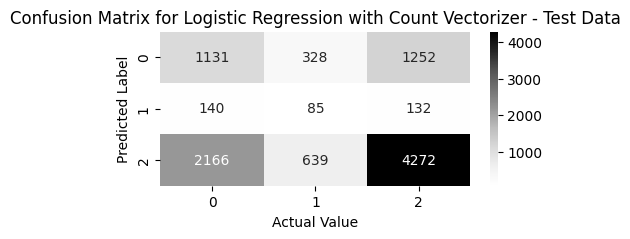

In [ ]:
lr = LogisticRegression(solver='lbfgs', max_iter=500, random_state=42, class_weight='balanced')

lr.fit(X_train_cv_combined, y_train)

y_pred_cv = lr.predict(X_test_cv_combined)

lr_f1_score = f1_score(y_test, y_pred_cv, average='macro')
print("F1 Score (macro-average):", lr_f1_score)

plt.figure(figsize=(5, 2))
cf_mat = confusion_matrix(y_test, y_pred_cv)
sns.heatmap(cf_mat, annot=True, fmt='g', cmap='Greys')
plt.xlabel("Actual Value")
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix for Logistic Regression with Count Vectorizer - Test Data")
plt.show()

In [ ]:
def LR_CV():
    print(f'Overall test F1 score: {lr_f1_score}')
    print(f'Training accuracy: {lr.score(X_train_cv_combined, y_train)}')
    print(f'Test accuracy: {lr.score(X_test_cv_combined, y_test)}')
    print("Classification report for logistic regression using Count Vectorizer")
    print(classification_report(y_test, y_pred_cv, target_names = ['Decent', 'Popular', 'Unpopular']))
    print('\n')

### Logistic Regression with TFIDF Vectorizer

In [ ]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_train_1_tfidf = tfidf.fit_transform(X_train_1)
X_test_1_tfidf = tfidf.transform(X_test_1)

X_train_text_tfidf_combined = hstack([X_train_tfidf, X_train_1_tfidf])
X_test_text_tfidf_combined = hstack([X_test_tfidf, X_test_1_tfidf])

ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_train_3_encoded = ohe.fit_transform(X_train_3.values.reshape(-1, 1))
X_test_3_encoded = ohe.transform(X_test_3.values.reshape(-1, 1))

X_train_tfidf_combined = hstack([X_train_text_tfidf_combined, X_train_2_scaled, X_train_3_encoded])
X_test_tfidf_combined = hstack([X_test_text_tfidf_combined, X_test_2_scaled, X_test_3_encoded])

# Check shapes of the final combined feature matrices
print("Shape of training set:", X_train_tfidf_combined.shape)
print("Shape of test set:", X_test_tfidf_combined.shape)

Shape of training set: (40580, 18670)
Shape of test set: (10145, 18670)


F1 Score (macro-average): 0.38958963295081156


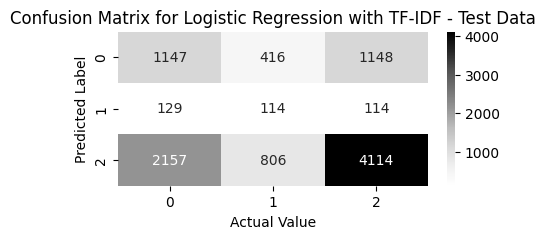

In [ ]:
lr2 = LogisticRegression(solver='lbfgs', max_iter=500, random_state=42, class_weight='balanced')

lr2.fit(X_train_tfidf_combined, y_train)

y_pred_tfidf = lr2.predict(X_test_tfidf_combined)

lr2_f1_score = f1_score(y_test, y_pred_tfidf, average='macro')
print("F1 Score (macro-average):", lr2_f1_score)

plt.figure(figsize=(5, 2))
cf_mat = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cf_mat, annot=True, fmt='g', cmap='Greys')
plt.xlabel("Actual Value")
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix for Logistic Regression with TF-IDF - Test Data")
plt.show()

In [ ]:
def LR_TFIDF():
    print(f'Overall test F1 score: {lr2_f1_score}')
    print(f'Training accuracy: {lr2.score(X_train_tfidf_combined, y_train)}')
    print(f'Test accuracy: {lr2.score(X_test_tfidf_combined, y_test)}')
    print("Classification report for logistic regression using TFIDF Vectorizer")
    print(classification_report(y_test, y_pred_tfidf, target_names = ['Decent', 'Popular', 'Unpopular']))
    print('\n')

## Naive Bayes With Count Vectorizer

In [ ]:
scaler = MaxAbsScaler()
X_train_2_scaled = scaler.fit_transform(X_train_2.values.reshape(-1, 1))
X_test_2_scaled = scaler.transform(X_test_2.values.reshape(-1, 1))

ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_train_3_encoded = ohe.fit_transform(X_train_3.values.reshape(-1, 1))
X_test_3_encoded = ohe.transform(X_test_3.values.reshape(-1, 1))

X_train_nb_cv_combined = hstack([X_train_text_combined, X_train_2_scaled, X_train_3_encoded])
X_test_nb_cv_combined = hstack([X_test_text_combined, X_test_2_scaled, X_test_3_encoded])

In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_list = list((class_weights))

F1 Score (macro-average) for Naive Bayes CV: 0.33714178387380017


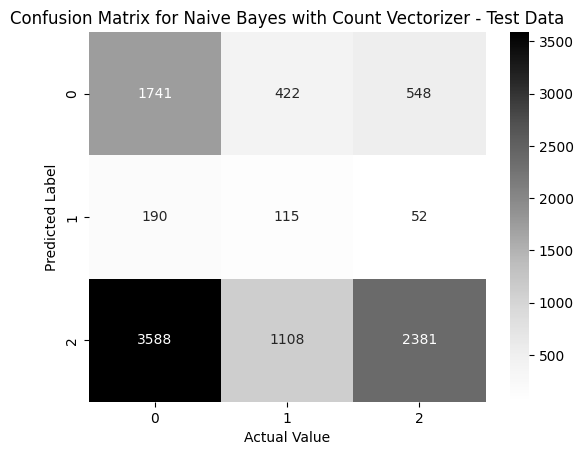

In [ ]:
naive_bayes_cv = MultinomialNB(class_prior=class_weight_list)
naive_bayes_cv.fit(X_train_nb_cv_combined, y_train)

y_pred_nb_cv = naive_bayes_cv.predict(X_test_nb_cv_combined)

nb_cv_f1_score = f1_score(y_test, y_pred_nb_cv, average='macro')
print("F1 Score (macro-average) for Naive Bayes CV:", nb_cv_f1_score)

cf_mat = confusion_matrix(y_test, y_pred_nb_cv)
sns.heatmap(cf_mat, annot=True, fmt='g', cmap='Greys')
plt.xlabel("Actual Value")
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix for Naive Bayes with Count Vectorizer - Test Data")
plt.show()

In [ ]:
def NB_CV():
    print(f'Overall test F1 score: {nb_cv_f1_score}')
    print(f'Training accuracy: {naive_bayes_cv.score(X_train_nb_cv_combined, y_train)}')
    print(f'Test accuracy: {naive_bayes_cv.score(X_test_nb_cv_combined, y_test)}')
    print("Classification report for Naive Bayes using Count Vectorizer")
    print(classification_report(y_test, y_pred_nb_cv, target_names = ['Decent', 'Popular', 'Unpopular']))
    print('\n')


## Naive Bayes Model with TFIDF Vectorizer

In [ ]:
scaler = MaxAbsScaler()
X_train_2_scaled = scaler.fit_transform(X_train_2.values.reshape(-1, 1))
X_test_2_scaled = scaler.transform(X_test_2.values.reshape(-1, 1))

ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_train_3_encoded = ohe.fit_transform(X_train_3.values.reshape(-1, 1))
X_test_3_encoded = ohe.transform(X_test_3.values.reshape(-1, 1))

X_train_nb_tfidf_combined = hstack([X_train_text_tfidf_combined, X_train_2_scaled, X_train_3_encoded])
X_test_nb_tfidf_combined = hstack([X_test_text_tfidf_combined, X_test_2_scaled, X_test_3_encoded])

F1 Score (macro-average) for Naive Bayes TF-IDF: 0.3236340490950962


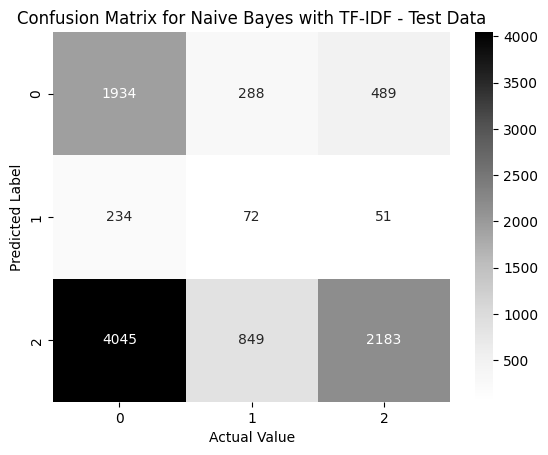

In [ ]:
# Naive Bayes model with TF-IDF
naive_bayes_tfidf = MultinomialNB(class_prior=class_weight_list)
naive_bayes_tfidf.fit(X_train_nb_tfidf_combined, y_train)

y_pred_nb_tfidf = naive_bayes_tfidf.predict(X_test_nb_tfidf_combined)

nb_tfidf_f1_score = f1_score(y_test, y_pred_nb_tfidf, average='macro')
print("F1 Score (macro-average) for Naive Bayes TF-IDF:", nb_tfidf_f1_score)

cf_mat = confusion_matrix(y_test, y_pred_nb_tfidf)
sns.heatmap(cf_mat, annot=True, fmt='g', cmap='Greys')
plt.xlabel("Actual Value")
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix for Naive Bayes with TF-IDF - Test Data")
plt.show()

In [ ]:
def NB_TFIDF():
    print(f'Overall test F1 score: {nb_tfidf_f1_score}')
    print(f'Training accuracy: {naive_bayes_tfidf.score(X_train_nb_tfidf_combined, y_train)}')
    print(f'Test accuracy: {naive_bayes_tfidf.score(X_test_nb_tfidf_combined, y_test)}')
    print("Classification report for Naive Bayes using TFIDF Vectorizer")
    print(classification_report(y_test, y_pred_nb_tfidf, target_names = ['Decent', 'Popular', 'Unpopular']))
    print('\n')

In [ ]:
LR_CV()
LR_TFIDF()
NB_CV()
NB_TFIDF()

Overall test F1 score: 0.38652993460630364
Training accuracy: 0.7264169541646132
Test accuracy: 0.5409561360275998
Classification report for logistic regression using Count Vectorizer
              precision    recall  f1-score   support

      Decent       0.33      0.42      0.37      2711
     Popular       0.08      0.24      0.12       357
   Unpopular       0.76      0.60      0.67      7077

    accuracy                           0.54     10145
   macro avg       0.39      0.42      0.39     10145
weighted avg       0.62      0.54      0.57     10145



Overall test F1 score: 0.38958963295081156
Training accuracy: 0.6641941843272549
Test accuracy: 0.5298176441596846
Classification report for logistic regression using TFIDF Vectorizer
              precision    recall  f1-score   support

      Decent       0.33      0.42      0.37      2711
     Popular       0.09      0.32      0.13       357
   Unpopular       0.77      0.58      0.66      7077

    accuracy                   